In [1]:
!export PYARROW_IGNORE_TIMEZONE=1
!pip install pyspark==3.3
!pip install pyarrow==11.0.0
!pip install matplotlib==3.6.0


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [17]:
from copy import deepcopy
from decimal import Decimal
from functools import reduce
from io import StringIO
from logging import getLogger, basicConfig
from typing import Tuple
from pprint import pprint

from matplotlib import pyplot
from pandas import DataFrame as PandasDataFrame
from pandas import concat, read_csv
from pyspark.ml import Estimator, Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import (BinaryClassificationEvaluator,
                                   MulticlassClassificationEvaluator,
                                   RegressionEvaluator)
from pyspark.ml.feature import (Imputer, OneHotEncoder, QuantileDiscretizer,
                                SQLTransformer, StringIndexer, VectorAssembler)
from pyspark.ml.regression import (DecisionTreeRegressor, GBTRegressor,
                                   GeneralizedLinearRegression,
                                   RandomForestRegressor)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import DataFrame as SparkDataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import (col, length, levenshtein, rand,
                                   regexp_replace, stddev, udf, when)
from pyspark.sql.types import BooleanType
from requests import get
from numpy import polyfit, asarray, polyval

logger = getLogger(__name__)
logger.setLevel(level='INFO')
basicConfig()

UNIVERSAL_SEED = 42

test_pollution = True
plot_learning_curve = False

class Juran:
    
    NUMERIC = ('bigint','int', 'double', 'float')

    def __init__(self, standard_deviation_range: int=6) -> None:
        self.standard_deviation_range = standard_deviation_range

    def calculate_data_quality(self, dataframe: SparkDataFrame) -> float:
        completeness_score = self.calculate_completeness_score(dataframe)
        accurateness_score = self.calculate_accurateness_score(dataframe)
        return round(completeness_score * accurateness_score, 4)
        
    def calculate_completeness_score(self, dataframe: SparkDataFrame) -> float:
        return 1 - self.percentage_of_missing_values(dataframe)
    
    def calculate_accurateness_score(self, dataframe: SparkDataFrame) -> float:
        return 1 - self.percentage_of_strange_values(dataframe)
    
    @staticmethod
    def filter_out_missing(dataframe: SparkDataFrame, column: str) -> SparkDataFrame:
        return dataframe.filter(
            ~(
                col(column).isNull() 
                | (length(regexp_replace(column, r"[\t\n ]+", "")) == 0)
            )
        )
    
    def percentage_of_missing_values(self, dataframe: SparkDataFrame) -> float:
        non_missing_count = 0
        for column in dataframe.columns:
            non_missing_count += self.filter_out_missing(dataframe, column).count()
        total_cells = dataframe.count() * len(dataframe.columns)
        return (1 - (non_missing_count / total_cells))

    def percentage_of_outliers_without_missing_values(
        self, dataframe: SparkDataFrame, column: str
    ) -> float:
        filtered = self.filter_out_missing(dataframe, column)

        mean_value = filtered.select(column).agg({"*": "avg"}).collect()[0][0]
        standard_deviation = filtered.select(stddev(column)).collect()[0][0]
        upper_limit = mean_value + (self.standard_deviation_range/2) * standard_deviation
        lower_limit = mean_value - (self.standard_deviation_range/2) * standard_deviation
        total_count = filtered.count()

        outliers_count = filtered.filter(
            (col(column) > upper_limit) | (col(column) < lower_limit)
        ).count()

        return outliers_count / total_count * 100

    def percentage_of_potential_typos_without_missing_values(
        self,
        dataframe: SparkDataFrame,
        column: str,
        edit_distance_threshold: int=2
    ) -> float:

        levenshtein_udf = udf(lambda str1, str2: levenshtein(str1, str2) <= 2, BooleanType())

        non_missing = self.filter_out_missing(dataframe, column)
        filtered = non_missing.filter(length(column) > 3)

        total_cells = filtered.select(column).count()

        matching_cells = filtered.alias('d1') \
            .join(filtered.alias('d2'), on=col('d1.' + column) != col('d2.' + column)) \
            .filter(levenshtein_udf(col('d1.' + column), col('d2.' + column))) \
            .select(col('d1.' + column)) \
            .distinct() \
            .count()

        percentage = (matching_cells / total_cells) * 100

        return percentage

    def percentage_of_strange_values(self, dataframe: SparkDataFrame) -> float:
        result = 1
        for column, data_type in dataframe.dtypes:
            if data_type in self.NUMERIC:
                result *= self.percentage_of_outliers_without_missing_values(
                    dataframe, column
                )
            else:
                result *= self.percentage_of_potential_typos_without_missing_values(
                    dataframe, column
                )
        return result

    @staticmethod
    def pollute_with_nulls(dataframe, null_ratio):
        for column in dataframe.columns:
            dataframe = dataframe.withColumn(
                column, when(rand() < null_ratio, None).otherwise(
                    col(column)
                )
            )
        
        return dataframe


def load_stratified_wine_quality() -> Tuple[SparkDataFrame, SparkDataFrame]:
    logger.info('Loading wine data')
    WINE_QUALITY_BASE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/'
    RED_WINES_FILENAME = 'winequality-red.csv'
    WHITE_WINES_FILENAME = 'winequality-white.csv'
    TARGET_COLUMN = 'quality'

    red_wines_csv = get(
        f'{WINE_QUALITY_BASE_URL}{RED_WINES_FILENAME}'
    )
    white_wines_csv = get(
        f'{WINE_QUALITY_BASE_URL}{WHITE_WINES_FILENAME}'
    )
    red_wines_df = read_csv(StringIO(red_wines_csv.text), sep=';')
    red_wines_df['color'] = 'red'
    white_wines_df = read_csv(StringIO(white_wines_csv.text), sep=';')
    white_wines_df['color'] = 'white'
    data = concat(
        [red_wines_df, white_wines_df]
    )
    data.rename(columns={TARGET_COLUMN: 'target'}, inplace=True)
    spark_dataframe = spark.createDataFrame(data)
    discretizer = QuantileDiscretizer(
        numBuckets=10,
        inputCol='target',
        outputCol='bucket'
    )
    spark_dataframe = discretizer.fit(spark_dataframe).transform(spark_dataframe)
    fractions = spark_dataframe.groupBy('bucket').count().withColumn(
        'fraction', col('count') / spark_dataframe.count()
    ).select('bucket', 'fraction').rdd.collectAsMap()
    train_df = spark_dataframe.stat.sampleBy('bucket', fractions, seed=UNIVERSAL_SEED)
    test_df = spark_dataframe.subtract(train_df)
    train_df = train_df.drop('bucket')
    test_df = test_df.drop('bucket')
    logger.info('Finished loading wine data')
    return train_df, test_df
    

def load_census_income() -> Tuple[SparkDataFrame, SparkDataFrame]:
    ADULT_BASE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/'
    TRAIN_DATA = 'adult.data'
    TEST_DATA = 'adult.test'
    TARGET_COLUMN = 'income'

    adult_train_csv = get(f'{CENSUS_INCOME_URL}{TRAIN_DATA}')
    adult_test_csv = get(f'{CENSUS_INCOME_URL}{TEST_DATA}')
    adult_train_df = read_csv(StringIO(adult_train_csv.text), sep=',')
    adult_test_df = read_csv(StringIO(adult_test_csv.text), sep=',')
    adult_train_df.rename(columns={TARGET_COLUMN: 'target'}, inplace=True)
    adult_test_df.rename(columns={TARGET_COLUMN: 'target'}, inplace=True)
    train_df = spark.createDataFrame(adult_train_df)
    test_df = spark.createDataFrame(adult_test_df)
    return train_df, test_df

    
def display_head(spark_df: SparkDataFrame, number_of_rows: int=5) -> PandasDataFrame:
    return spark_df.limit(number_of_rows).toPandas().head(number_of_rows)

def get_regression_estimators(target_column: str='target') -> set:
    return {
        regressor(labelCol=target_column, **options) for regressor, options in {
            GeneralizedLinearRegression: {'regParam': .05}, 
            DecisionTreeRegressor: {'minInfoGain': .05},
            RandomForestRegressor: {'maxDepth': 10},
            GBTRegressor: {},
        }.items()
    }

def get_dataset_pipeline(
    dataframe: SparkDataFrame,
    estimator: Estimator,
    task: str='regression',
    target_column: str='target',
    number_of_folds: int=5,
    metric_name: str='rmse'
) -> Pipeline:
    NUMERIC = ('bigint','int', 'double', 'float')
    evaluation_mapper = {
        'regression': RegressionEvaluator,
        'multiclass_classification': MulticlassClassificationEvaluator,
        'binary_classification': BinaryClassificationEvaluator,
    }
    numerical_columns = [
        column for column, data_type in dataframe.dtypes if data_type in NUMERIC
    ]
    logger.debug(f'Numerical columns: {numerical_columns}')
    categorical_columns = [
        column for column in dataframe.columns if column not in numerical_columns
    ]
    logger.debug(f'Categorical columns: {categorical_columns}')
    indexed_columns = [
        f'{column}_index' for column in categorical_columns
    ]
    one_hot_encoded_columns = [
        f'{column}_ohe' for column in categorical_columns
    ]
    features = [
        *[
            column for column in numerical_columns if target_column not in column
        ],
        *[
            column for column in one_hot_encoded_columns if target_column not in column
        ],
    ]
    numerical_imputer = Imputer(
        inputCols=numerical_columns,
        outputCols=numerical_columns,
        strategy='median'
    )
    string_indexer = StringIndexer(
        inputCols=categorical_columns,
        outputCols=indexed_columns,
        handleInvalid='keep'
    )
    one_hot_encoder = OneHotEncoder(
        inputCols=indexed_columns,
        outputCols=one_hot_encoded_columns
    )
    sql_transformer = SQLTransformer(
        statement="SELECT *, IF(EXISTS(SELECT target_ohe FROM __THIS__), target_ohe AS target, target) AS target FROM __THIS__"
    )
    assembler = VectorAssembler(
        inputCols=features,
        outputCol="features"
    )
    cross_validator = CrossValidator(
        estimator=estimator,
        estimatorParamMaps=ParamGridBuilder().build(),
        evaluator=evaluation_mapper[task](
            labelCol=target_column
        ),
        numFolds=number_of_folds
    )

    return Pipeline(
        stages=[
            numerical_imputer,
            string_indexer,
            one_hot_encoder,
            assembler,
            cross_validator,
        ]
    )

In [3]:
if __name__ == '__main__':
    
    spark = SparkSession.builder.master(
                "local[1]"
            ).appName(
                "Juran"
            ).getOrCreate()
            
    juran = Juran()

    train_data, test_data = load_stratified_wine_quality()
    
    original_train_data_quality_score = juran.calculate_data_quality(train_data)
    
    polluted_train_data = list()
    
    for ratio in (factor * .05 for factor in range(1, 11)):
        data = juran.pollute_with_nulls(train_data, ratio)
        polluted_train_data.append(
            {
                'data': data,
                'quality_score': juran.calculate_data_quality(data)
            }
        )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/03 00:09:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


INFO:__main__:Loading wine data
/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


23/03/03 00:09:44 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 4 buckets as a result.


INFO:__main__:Finished loading wine data


In [8]:
estimator_results = dict()
for estimator in get_regression_estimators():
    estimator_name = estimator.__class__.__name__
    logger.info(f'Executing analysis for {estimator_name}')
    model = get_dataset_pipeline(
        train_data, estimator, task='regression', metric_name='rmse'
    )
    logger.info('Executing cross validation')
    trained_model = model.fit(train_data)
    logger.info('Cross validation executed')
    average_rmse = round(trained_model.stages[-1].avgMetrics[0],4)
    average_stddev = round(trained_model.stages[-1].stdMetrics[0],4)
    logger.info(f'Average root mean squared error: {average_rmse}')
    logger.info(f'Average standard deviation: {average_stddev}')
    estimator_results[estimator_name] = {
        'cross_validation_average_rmse': average_rmse,
        'cross_vaidation_average_stddev': average_stddev
    }
    if plot_learning_curve:
        train_sizes = tuple(
            float(
                Decimal(value) * Decimal('0.05') + Decimal('0.1')
            ) for value in range(16)
        )

        train_errors = list()
        test_errors = list()

        for size in train_sizes:
            test_evaluator = RegressionEvaluator(labelCol='target')
            train_data_current, test_data_current = train_data.randomSplit(
                [size, 1-size], seed=UNIVERSAL_SEED
            )
            trained_model = model.fit(train_data_current)
            train_error = trained_model.stages[-1].avgMetrics[0]
            test_error = test_evaluator.evaluate(
                trained_model.transform(test_data_current)
            )
            logger.debug(f'Train score: {train_error}')
            logger.debug(f'Validation score: {test_error}')
            train_errors.append(train_error)
            test_errors.append(test_error)

        logger.info(f'Plotting learning curve for {estimator_name}')
        pyplot.plot(train_sizes, train_errors, '-o', label='Train')
        pyplot.plot(train_sizes, test_errors, '-o', label='Test')
        pyplot.title(f'Learning Curve for {estimator_name}')
        pyplot.xlabel('Training Set Size')
        pyplot.ylabel('RMSE Score')
        pyplot.legend(loc='best')
        pyplot.show()
    
    if test_pollution:
        pollution_results = list()
        for current_train_data in polluted_train_data:
            current_train_data_copy = current_train_data.copy()
            pollution_evaluator = RegressionEvaluator(labelCol='target')
            polluted_model = model.fit(current_train_data_copy['data'])
            current_train_data_copy['error'] = round(
                pollution_evaluator.evaluate(
                    polluted_model.transform(test_data)
                ),
                4
            )
            current_train_data_copy.pop('data')
            pollution_results.append(current_train_data_copy)
    estimator_results[estimator_name]['pollution_test'] = pollution_results
    
pprint(estimator_results)

INFO:__main__:Executing analysis for GBTRegressor
INFO:__main__:Executing cross validation
INFO:__main__:Cross validation executed
INFO:__main__:Average root mean squared error: 0.6077
INFO:__main__:Average standard deviation: 0.0244
INFO:__main__:Executing analysis for GeneralizedLinearRegression
INFO:__main__:Executing cross validation
INFO:__main__:Cross validation executed
INFO:__main__:Average root mean squared error: 0.588
INFO:__main__:Average standard deviation: 0.0279
INFO:__main__:Executing analysis for RandomForestRegressor
INFO:__main__:Executing cross validation


23/03/03 00:46:18 WARN DAGScheduler: Broadcasting large task binary with size 1066.3 KiB
23/03/03 00:46:19 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB
23/03/03 00:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1052.5 KiB
23/03/03 00:46:21 WARN DAGScheduler: Broadcasting large task binary with size 1023.9 KiB
23/03/03 00:46:22 WARN DAGScheduler: Broadcasting large task binary with size 1093.3 KiB


INFO:__main__:Cross validation executed
INFO:__main__:Average root mean squared error: 0.561
INFO:__main__:Average standard deviation: 0.0197


23/03/03 00:46:23 WARN DAGScheduler: Broadcasting large task binary with size 1108.1 KiB
23/03/03 00:46:24 WARN DAGScheduler: Broadcasting large task binary with size 1029.2 KiB
23/03/03 00:46:25 WARN DAGScheduler: Broadcasting large task binary with size 1029.0 KiB
23/03/03 00:46:27 WARN DAGScheduler: Broadcasting large task binary with size 1041.9 KiB
23/03/03 00:46:28 WARN DAGScheduler: Broadcasting large task binary with size 1003.8 KiB
23/03/03 00:46:29 WARN DAGScheduler: Broadcasting large task binary with size 1059.3 KiB
23/03/03 00:46:30 WARN DAGScheduler: Broadcasting large task binary with size 1124.2 KiB
23/03/03 00:46:31 WARN DAGScheduler: Broadcasting large task binary with size 1021.4 KiB
23/03/03 00:46:32 WARN DAGScheduler: Broadcasting large task binary with size 1019.7 KiB
23/03/03 00:46:33 WARN DAGScheduler: Broadcasting large task binary with size 1053.1 KiB
23/03/03 00:46:34 WARN DAGScheduler: Broadcasting large task binary with size 1004.8 KiB
23/03/03 00:46:36 WAR

INFO:__main__:Executing analysis for DecisionTreeRegressor
INFO:__main__:Executing cross validation
INFO:__main__:Cross validation executed
INFO:__main__:Average root mean squared error: 0.6238
INFO:__main__:Average standard deviation: 0.0251


{'DecisionTreeRegressor': {'cross_vaidation_average_stddev': 0.0251,
                           'cross_validation_average_rmse': 0.6238,
                           'pollution_test': [{'error': 0.9083,
                                               'quality_score': 0.9506},
                                              {'error': 0.9114,
                                               'quality_score': 0.8991},
                                              {'error': 0.9833,
                                               'quality_score': 0.8486},
                                              {'error': 0.9837,
                                               'quality_score': 0.7961},
                                              {'error': 0.9841,
                                               'quality_score': 0.7462},
                                              {'error': 0.985,
                                               'quality_score': 0.6997},
                                          

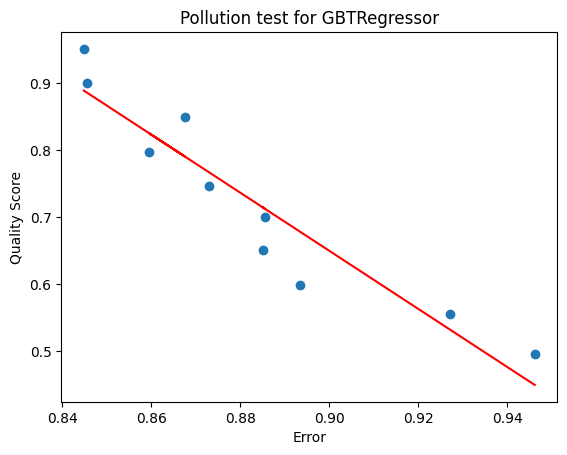

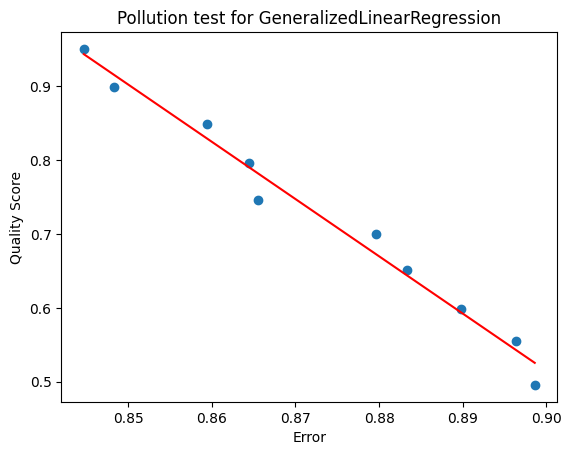

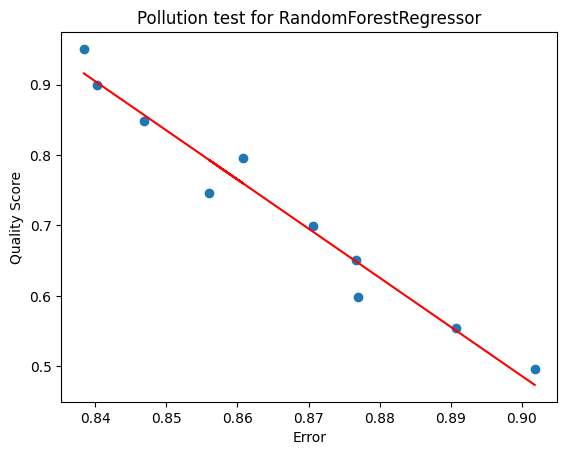

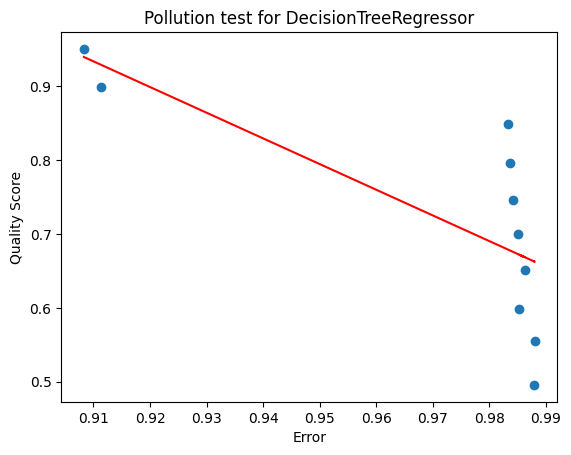

In [20]:
for estimator_name, data in estimator_results.items():
    pollution_test_data = data['pollution_test']
    x_values = asarray([point['error'] for point in pollution_test_data])
    y_values = asarray([point['quality_score'] for point in pollution_test_data])

    pyplot.title(f'Pollution test for {estimator_name}')
    pyplot.scatter(x_values, y_values)
    pyplot.plot(
        x_values, polyval(polyfit(x_values, y_values,1), x_values),
        color='red'
    )
    pyplot.xlabel('Error')
    pyplot.ylabel('Quality Score')
    pyplot.show()